<a href="https://colab.research.google.com/github/francisbonheur/alyra_projet_deep_learning/blob/main/ML_detection_valeur_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning : prédiction de la valeur humaine "famille et tradition"

A partir des données issues de l'European Social Survey.  
Dataset :  
 - [European social survey dataset generator](https://ess.sikt.no/en/data-builder/?tab=download&variables=0.8+1.0.30_40_58-60_73-76+2.0.64_65_68_76+3.1_87+4.0.8_22_30_31_47_74_76_90-93_132+5.4_6_8_12_16+9.25_28&seriesVersion=920&rounds=0+1+2+3+4+5+6+7+8+9+10+11)

## Chargement des frameworks python

In [57]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from rpy2.robjects.packages import importr

from sklearn.model_selection import train_test_split

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

## Chargement du dataset

In [58]:
# Lecture du dataset (fichier CSV)
# L'index est composé des colonnes qui permettent d'identifier de façon unique l'individu
# 0 : name - Title of dataset
# 1 : essround - ESS round
# 2 : edition - Edition
# 3 : proddate - Production date
# 4 : idno - Respondent's identification number
# 5 : cntry - Country
df = pd.read_csv('https://raw.githubusercontent.com/francisbonheur/alyra_project_machine_learning/refs/heads/main/ESSfull-20251120.csv', header=0, index_col=[0,1,2,3,4])

df = df.reset_index(drop=True)

# Vérification du nombre de doublons
print(f"Nombre de doublons : {df.index.duplicated().sum()}")

# Ces colonnes decrive le dataset et ne représentent pas des features
ess_description_columns_name = ['dweight', 'pspwght', 'pweight', 'anweight', 'prob', 'stratum', 'psu']

available_labels_names = ['ipbhprp', 'impfun', 'imptrad', 'imprich', 'impfree']

label_name = 'imptrad'

available_labels_names.remove(label_name)

# On ne conserve que les données utiles pour la prédiction
data_without_description = df.drop(columns=ess_description_columns_name, axis=1)

# On ne s'interresse qu'aux données françaises
french_data_only = data_without_description[data_without_description['cntry'] == 'FR']
french_data_only = french_data_only.drop(columns=['cntry'], axis=1)

# On se conserve que le label à prédire "famille et tradition"
data_without_useless_labels = french_data_only.drop(columns=available_labels_names, axis=1)

data_without_useless_labels.info()


Nombre de doublons : 0
<class 'pandas.core.frame.DataFrame'>
Index: 20809 entries, 15710 to 507701
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ppltrst   20809 non-null  int64  
 1   implvdm   3945 non-null   float64
 2   lrscale   20809 non-null  int64  
 3   polintr   20809 non-null  int64  
 4   trstlgl   20809 non-null  int64  
 5   trstplc   20809 non-null  int64  
 6   trstplt   20809 non-null  int64  
 7   imwbcnt   20809 non-null  int64  
 8   volunfp   3748 non-null   float64
 9   lrnobed   3748 non-null   float64
 10  loylead   3748 non-null   float64
 11  rlgdgr    20809 non-null  int64  
 12  rlgdnm    17500 non-null  float64
 13  sclmeet   20809 non-null  int64  
 14  wrclmch   5818 non-null   float64
 15  gndr      20809 non-null  int64  
 16  agea      20809 non-null  int64  
 17  chldhm    15051 non-null  float64
 18  domicil   20809 non-null  int64  
 19  edulvla   7368 non-null   float64
 20  edulv

## Nettoyage des données

### Suppression des valeurs représentant une "non réponse"
Le sondé à la possibilité de ne pas répondre au questions posées.  
La non réponse peut correpondre aux cas suivants :
- Le sondé ne souhaite pas répondre
- Le sondé ne sait pas
- La question n'est pas applicable au sondé
- Pas de réponse

Chaque cas de "non réponse" est codé de façon différente dans chaque question. Il s'agit ici de considérer tous les cas de non réponse de la même façon. C'est à dire par une valeur manquante (nan de numpy) qui fera l'object d'une imputation plus tard.

In [59]:
# Matrice des noms de colonnes et des valeurs à remplacer
missing_values_dict = {
    'polintr': [7, 8, 9],
    'rlgdgr': [77, 88, 99],
    'rlgdnm': [66,77, 88, 99],
    'sclmeet': [77, 88, 99],
    'gndr': [9],
    'agea': [999],
    'chldhm': [9], # impossible de faire la différence avec le cas "9 enfants à la maison
    'edulvla': [77, 88, 99],
    'edulvlb': [7777, 8888, 9999],
    'emplrel': [7, 8, 9],
    'isco08': [66666, 77777, 88888, 99999],
    'iscoco': [66666, 77777, 88888, 99999],
    'marital': [7, 8, 9],
    'maritala': [77, 88, 99],
    'maritalb': [77, 88, 99],
    'marsts': [66, 77, 88, 99],
    'tporgwk': [66, 77, 88, 99],
    'imptrad': [7, 8, 9],
    'impfree': [7, 8, 9],
    'imprich': [7, 8, 9],
    'ipbhprp': [7, 8, 9],
    'impfun' : [7, 8, 9],
    'ppltrst' : [77,88,99],
    'implvdm' : [77,88,99],
    'lrscale' : [77,88,99],
    'trstlgl' :  [77,88,99],
    'trstplc' : [77,88,99],
    'trstplt' : [77,88,99],
    'imwbcnt' :  [77,88,99],
    'volunfp' : [7,8,9],
    'lrnobed' : [7,8,9],
    'loylead' : [7,8,9],
    'wrclmch' : [6,7,8,9],
    'domicil' : [7,8,9]
}


data_without_no_reponse_codes = data_without_useless_labels.replace(missing_values_dict, np.nan)

for column in data_without_useless_labels.columns:
  print(f"Colonne : {column} - Cardinalité avant traitement : {len(data_without_useless_labels[column].unique())} -  Cardinalité après traitement : {len(data_without_no_reponse_codes[column].unique())}")

Colonne : ppltrst - Cardinalité avant traitement : 13 -  Cardinalité après traitement : 12
Colonne : implvdm - Cardinalité avant traitement : 14 -  Cardinalité après traitement : 12
Colonne : lrscale - Cardinalité avant traitement : 13 -  Cardinalité après traitement : 12
Colonne : polintr - Cardinalité avant traitement : 6 -  Cardinalité après traitement : 5
Colonne : trstlgl - Cardinalité avant traitement : 13 -  Cardinalité après traitement : 12
Colonne : trstplc - Cardinalité avant traitement : 13 -  Cardinalité après traitement : 12
Colonne : trstplt - Cardinalité avant traitement : 13 -  Cardinalité après traitement : 12
Colonne : imwbcnt - Cardinalité avant traitement : 13 -  Cardinalité après traitement : 12
Colonne : volunfp - Cardinalité avant traitement : 4 -  Cardinalité après traitement : 3
Colonne : lrnobed - Cardinalité avant traitement : 8 -  Cardinalité après traitement : 6
Colonne : loylead - Cardinalité avant traitement : 8 -  Cardinalité après traitement : 6
Colonne

### Suppression des lignes sans label
Suppression des individus sans label (le sondé n'a pas répondu à la question)  

In [60]:
# Suppression des lignes sans label
data_no_empty_label = data_without_no_reponse_codes.dropna(subset=[label_name])

print(f"Taille du dataset avant traitement {data_without_no_reponse_codes.shape}")
print(f"Taille du dataset après traitement {data_no_empty_label.shape}")

Taille du dataset avant traitement (20809, 30)
Taille du dataset après traitement (18632, 30)


### Simplification du problème
On commence par une classification simple (binaire) quitte à complexifier le problème par la suite

In [61]:
tradition_value_sensibility_matrix = {
    label_name : {
        1: 1,
        2: 1,
        3: 1,
        4: 0,
        5: 0,
        6: 0,
    }
}

data_label_simpfified = data_no_empty_label.replace(tradition_value_sensibility_matrix)

print(f"Classes possible : {data_label_simpfified[label_name].unique()}")

Classes possible : [1. 0.]


### Données manquantes par lignes

In [62]:
# Calcul du pourcentage de valeurs manquantes par ligne
missing_value_min_percent = min(data_label_simpfified.isnull().mean(axis=1) * 100)

if missing_value_min_percent > 15:
    print("Toutes les lignes ont plus de 15% de valeurs manquantes. La suppression est immossible on privilégie l'imputation")



Toutes les lignes ont plus de 15% de valeurs manquantes. La suppression est immossible on privilégie l'imputation


#### Feature enginering

Certaines colonnes doivent être mergées (modification du formulaire au cours des années)

<ins>Traitement des colonnes isco08 et iscoco</ins>  
- Jusqu'à la vague d'enquête n°5, la profession du sondé est recueilli dans le référentiel ISCO-88 (colonne iscoco)
- A partir de la vague d'enquête n°6, la profession du sondé est recueilli dans le référentiel ISCO-08 (colonne isco08)
- Merge des deux colonnes donnant la même information  
  - Conversion des données de la colonne isco08 dans le référentiel ISCO-88 (Utilisation d'une fonction R [ISCO08ConveRsions](https://cran.r-project.org/web/packages/ISCO08ConveRsions/index.html) )
  - Fusion des 2 colonnes dans une nouvelle colonne "occupation"

In [63]:
# Load R
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [64]:
# indicate that you're running R code
#%%R

# Install if it's your first time to run
#install.packages("ISCO08ConveRsions")

In [65]:
data_occupation_columns_merged = data_label_simpfified.copy()

# Nombre de lignes avec les deux colonnes isco08 et iscoco manquantes
missing_isco08_iscoco = data_occupation_columns_merged[data_occupation_columns_merged['isco08'].isnull() & data_occupation_columns_merged['iscoco'].isnull()]
print(f"Nombre de lignes sans l'information de la profession (colonnes isco08 et iscoco vides) : {len(missing_isco08_iscoco)}")

# Les deux colonnes sont complémentaires, on va faire du feature engineering pour créer une nouvelle colonne 'occupation' qui regroupe les deux informations

# installation du package R ISCO08ConveRsions nécessaire : install.packages("ISCO08ConveRsions")
ISCO08ConveRsions = importr('ISCO08ConveRsions')


# Méthode conversion des code professions ISCO 08 en ISCO 88
def isco08_to_isco88(code):
    try:
        # La fonction R ne sais pas convertir le code ISCO 08 '0', on le gère nous même
        if code == '0000':
            return code

        return ISCO08ConveRsions.isco08toisco88(code)[0]
    except:
        print(f"Conversion impossible pour le code ISCO 08 : {code}")
        return np.nan

# Get ISO code as string with leading zeros
def get_code(code_as_int):
    if pd.isnull(code_as_int):
        return np.nan

    return str(code_as_int).split('.')[0].zfill(4)

data_occupation_columns_merged['occupation_code'] = data_occupation_columns_merged.apply(
    lambda row: isco08_to_isco88(get_code(row['isco08'])) if pd.notnull(row['isco08']) else get_code(row['iscoco']),
    axis=1
)

# Nombre de lignes avec la colonne occupation manquante
missing_occupation = data_occupation_columns_merged[data_occupation_columns_merged['occupation_code'].isnull()]
print(f"Nombre de lignes sans l'information de la profession après feature engineering (colonne occupation vide) : {len(missing_occupation)}")

data_occupation_columns_merged['occupation'] = data_occupation_columns_merged['occupation_code'].str[0]

data_occupation_columns_merged = data_occupation_columns_merged.drop(columns=['occupation_code', 'isco08', 'iscoco'], axis=1)


Nombre de lignes sans l'information de la profession (colonnes isco08 et iscoco vides) : 1547
Nombre de lignes sans l'information de la profession après feature engineering (colonne occupation vide) : 1547


<ins>Traitement des colonnes edulvla et edulvlb</ins>  
- Jusqu'à la vague d'enquête n°4, le niveau d'étude du sondé est recueilli dans le référentiel ISCED simplifié (colonne edulvla contient 5 niveaux)
- A partir de la vague d'enquête n°5, le niveau d'étude du sondé est recueilli dans le référentiel ISCO-08 étendus (colonne edulvlb contient 27 niveaux)
- Merge des deux colonnes donnant la même information
  - Conversion des données de la colonnes edulvlb dans le référentiel ISCED simplifié (création d'une matrice mapping à partir de la documentation)
  - Fusion des deux colonnes dans une nouvelle colonne "education"

|       |Inclassable|ISCED 0-1|ISCED 2|ISCED 3|ISCED 4|ISCED 5-6|Other|
|-------|-----------|---------|-------|-------|-------|---------|-----|
|edulvla|          0|        1|                      2|                          3|                  4|        5| 55|
|edulvlb|           |    0,113|129,212,213<br>221,222,223|229,311,312<br>313,321,322,323|412,413,421<br>422,423|510,520,610<br>620,710,720,800|5555|

In [66]:
data_education_level_columns_merged = data_occupation_columns_merged.copy()
# Nombre de lignes avec les deux colonnes edulvla et edulvla manquantes
missing_edulvla_edulvlb = data_education_level_columns_merged[data_education_level_columns_merged['edulvla'].isnull() & data_education_level_columns_merged['edulvlb'].isnull()]
print(f"Nombre de lignes sans l'information du niveau d'étude (colonnes edulvla et edulvlb vides) : {len(missing_edulvla_edulvlb)}")

# Affichage des valeurs uniques de la colonne edulvlb avant le mapping
print("Valeurs uniques de la colonne edulvlb avant le mapping :")
print(data_education_level_columns_merged['edulvlb'].unique())

education_mapping_matrix = {
    'edulvlb': {
        0: 1,
        113: 1,
        129: 2,
        212: 2,
        213: 2,
        221: 2,
        222: 2,
        223: 2,
        229: 3,
        311: 3,
        312: 3,
        313: 3,
        321: 3,
        322: 3,
        323: 3,
        412: 4,
        413: 4,
        421: 4,
        422: 4,
        423: 4,
        510: 5,
        520: 5,
        610: 5,
        620: 5,
        710: 5,
        720: 5,
        800: 5,
        5555: 55
    }
}

data_education_level_columns_merged = data_education_level_columns_merged.replace(education_mapping_matrix)

# Affichage des valeurs uniques de la colonne edulvlb après le mapping
print("Valeurs uniques de la colonne edulvlb après le mapping :")
print(data_education_level_columns_merged['edulvlb'].unique())

# Création de la colonne education qui regroupe les deux colonnes edulvla et edulvlb
data_education_level_columns_merged['education'] = data_education_level_columns_merged.apply(
    lambda row: row['edulvla'] if pd.notnull(row['edulvla']) else get_code(row['edulvlb']),
    axis=1
)

data_education_level_columns_merged = data_education_level_columns_merged.drop(columns=['edulvla', 'edulvlb'], axis=1)

# Nombre de lignes avec la colonne occupation manquante
missing_education = data_education_level_columns_merged[data_education_level_columns_merged['education'].isnull()]
print(f"Nombre de lignes sans l'information du niveau d'étude après feature engineering (colonne education vide) : {len(missing_education)}")



Nombre de lignes sans l'information du niveau d'étude (colonnes edulvla et edulvlb vides) : 12
Valeurs uniques de la colonne edulvlb avant le mapping :
[  nan  720.  313.  113.  510.  321. 5555.  520.  323.  213.  620.  710.
  421.    0.  610.  800.  413.]
Valeurs uniques de la colonne edulvlb après le mapping :
[nan  5.  3.  1. 55.  2.  4.]
Nombre de lignes sans l'information du niveau d'étude après feature engineering (colonne education vide) : 12


<ins>Traitement des colonnes du statut marital</ins>
- Durant les vagues d'enquête n°1 et 2, le statut marital du sondé est recueilli dans la colonne marital (5 choix possibles)
- Durant les vagues d'enquête n°3 et 4, le statut marital du sondé est recueilli dans la colonne maritala (9 choix possibles)
- A partir de la vague d'enquête n°5, le statut marital du sondé est recueilli dans la colonne maritalb ou la colonne marsts (6 choix possible)
- Merge des colonnes de statut marital
  - Conversion des données des colonnes maritala, maritalb dans le référentiel de réponse de la colonne marital (création d'une matrice de correspondance des codes de status marital à partir de la documentation)
  - Fusion des colonnes dans une nouvelle colonne "marital_status"

|                | marital | maritala | maritalb | marsts |
|----------------|---------|----------|----------|--------|
| Married        | 1       | 1,2      | 1,2      | 1,2    |
| Separated      | 2       | 3,4      | 3        | 3      |
| Divorced       | 3       | 5,7      | 4        | 4      |
| Widowed        | 4       | 6,8      | 5        | 5      |
| Never married  | 5       | 9        | 6        | 6      |


marital     100.000000
maritala     78.375912
maritalb     38.133319
marsts       65.908115
dtype: float64
        maritalb  marsts
15710      False   False
15711      False   False
15712      False   False
15713      False   False
15714      False   False
...          ...     ...
444019      True    True
444020      True   False
444021      True   False
444022      True    True
444023      True   False

[18632 rows x 2 columns]


Text(0.5, 1.0, 'correlation matrix')

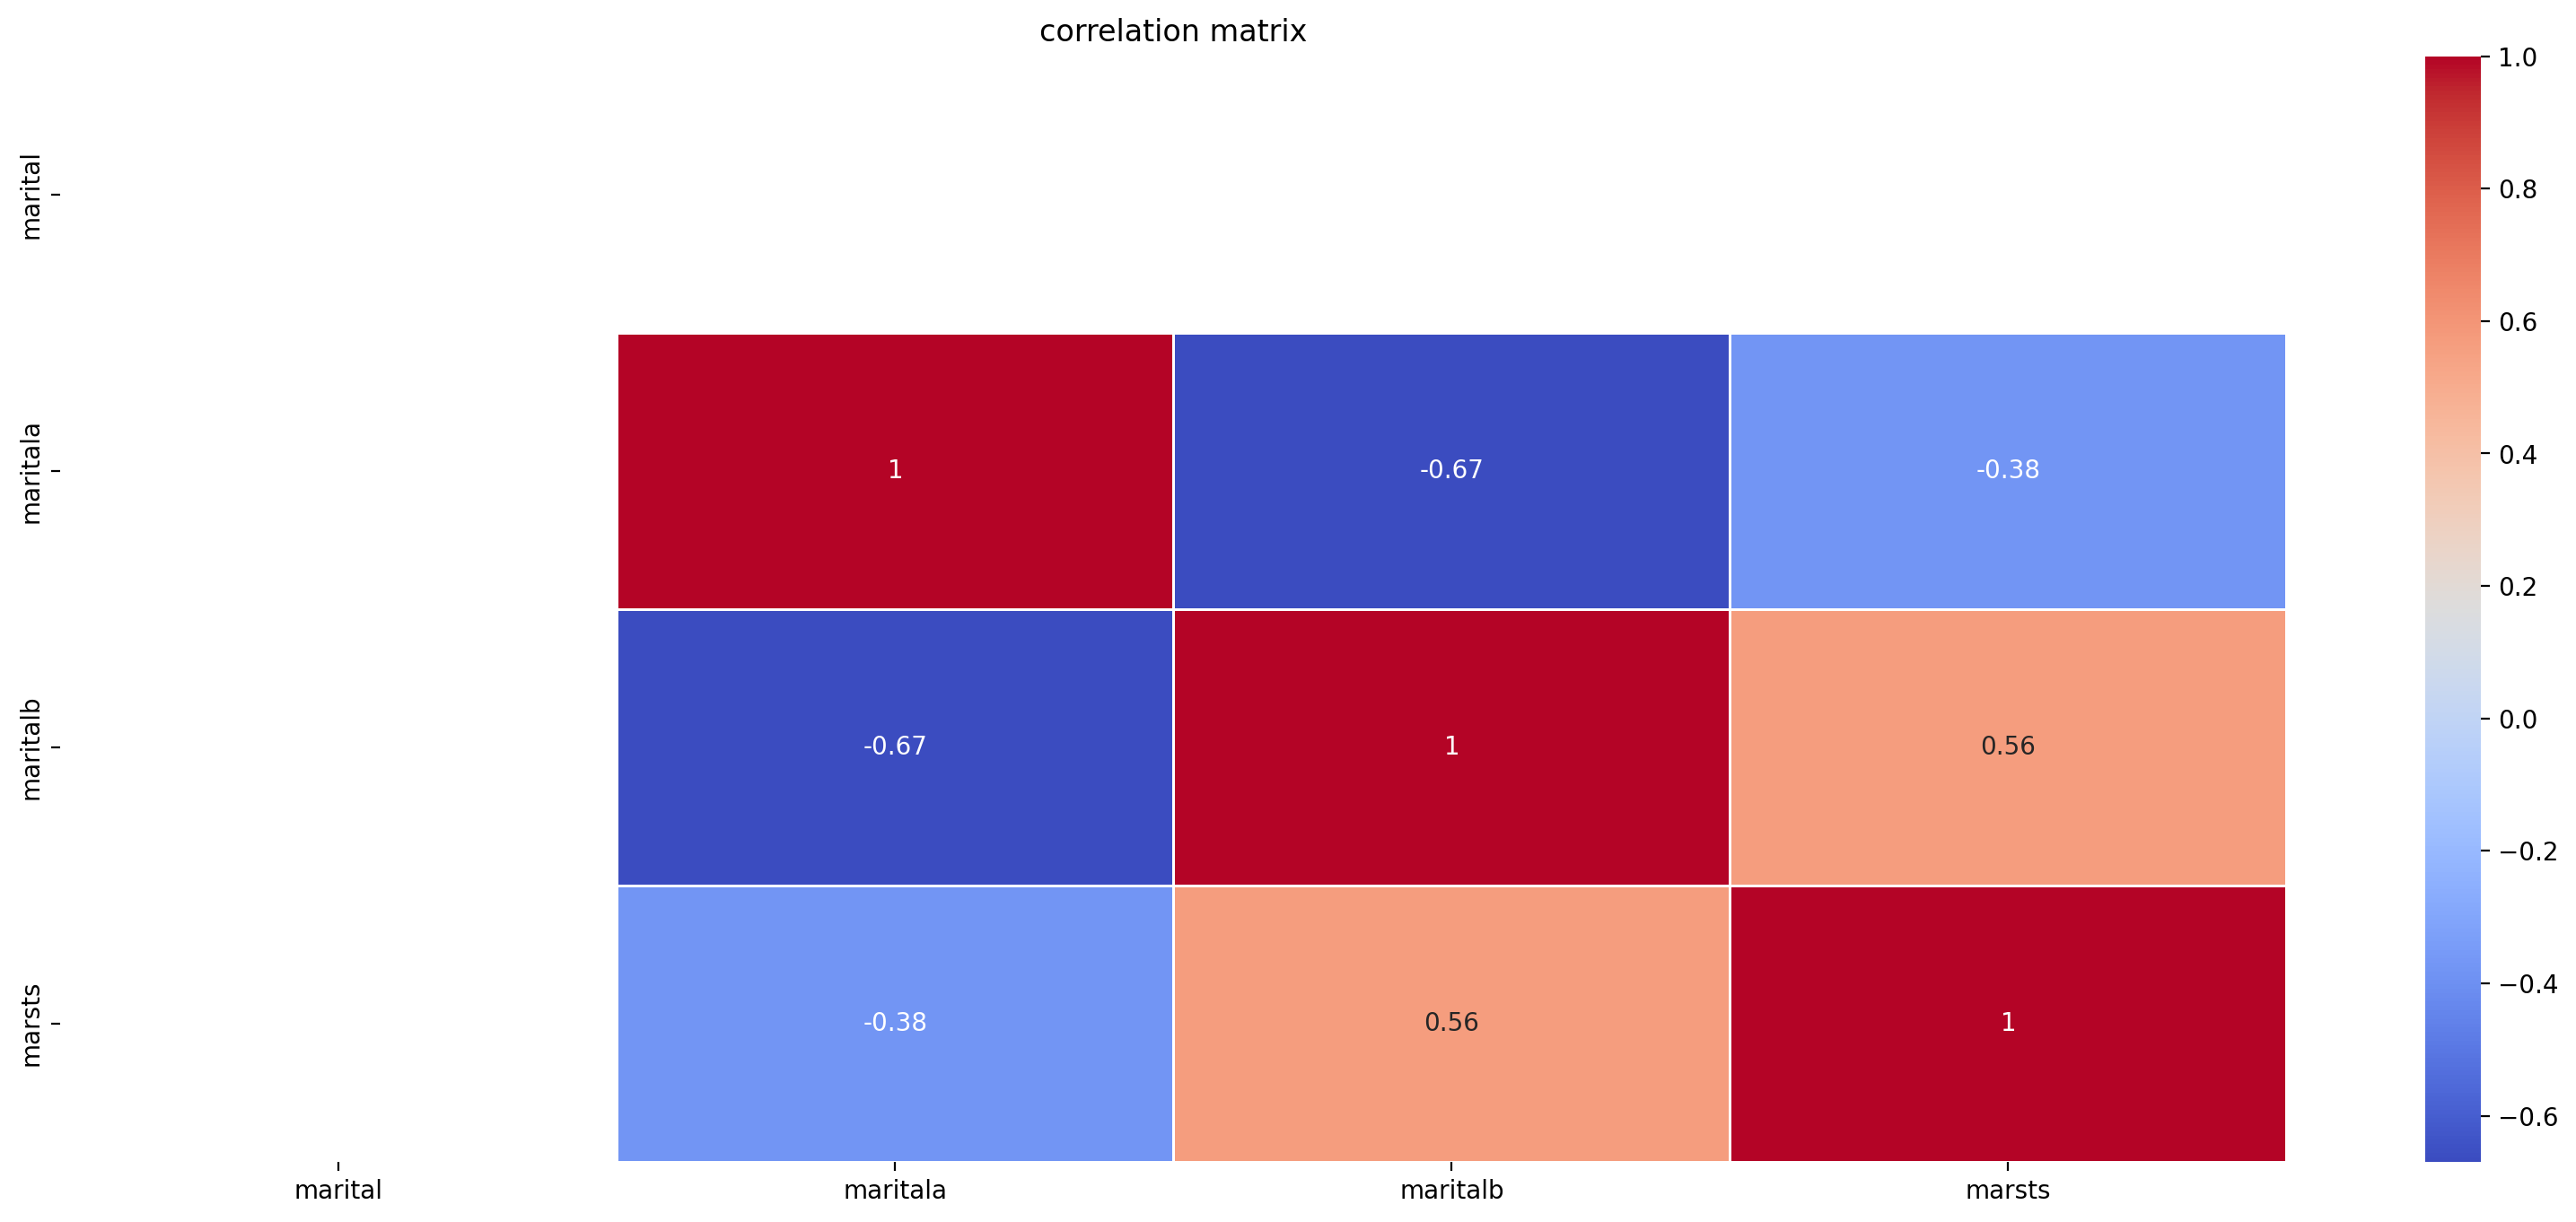

In [67]:
# Vérification de la présence de valeurs manquantes.
print(data_education_level_columns_merged[['marital', 'maritala', 'maritalb', 'marsts']].isnull().mean() * 100)

print(data_education_level_columns_merged[['maritalb', 'marsts']].notnull())

# Vérification de la corrélation entre les colonnes de statut marital
plt.figure(figsize=(20,8))
correlation_matrix = data_education_level_columns_merged[['marital', 'maritala', 'maritalb', 'marsts']].notnull().corr()
sns.heatmap(correlation_matrix, annot =True, cmap='coolwarm', linewidths=0.5)
plt.title('correlation matrix')

In [68]:
data_marital_status_columns_merged = data_education_level_columns_merged.copy()
# Nombre de lignes avec les colonnes marital, maritala, maritalb et marsts manquantes
missing_marital = data_marital_status_columns_merged[data_marital_status_columns_merged['maritala'].isnull() & data_marital_status_columns_merged['maritalb'].isnull()]
print(f"Nombre de lignes sans l'information du statut marital (colonnes maritala et maritalb vides) : {len(missing_marital)}")

print("Valeurs uniques des colonnes maritala, maritalb avant le mapping :")
print(data_marital_status_columns_merged['maritala'].unique())
print(data_marital_status_columns_merged['maritalb'].unique())


marital_status_mapping_matrix = {
    'maritala' : {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 3,
        7: 3,
        6: 4,
        8: 4,
        9: 5
    },
    'maritalb' : {
        1: 1,
        2: 1,
        3: 2,
        4: 3,
        5: 4,
        6: 5,
    }
}

data_marital_status_columns_merged = data_marital_status_columns_merged.replace(marital_status_mapping_matrix)

print("Valeurs uniques des colonnes maritala et maritalb après le mapping :")
print(data_marital_status_columns_merged['maritala'].unique())
print(data_marital_status_columns_merged['maritalb'].unique())


# Création de la colonne marital_status qui merge les 4 colonnes marital, maritala, maritalb et marsts
def get_marital_status(row):
    if pd.notnull(row['maritala']):
        return row['maritala']
    elif pd.notnull(row['maritalb']):
        return row['maritalb']
    else:
        return np.nan

data_marital_status_columns_merged['marital_status'] = data_marital_status_columns_merged.apply(
    lambda row: get_marital_status(row),
    axis=1
)

data_marital_status_columns_merged = data_marital_status_columns_merged.drop(columns=['marital', 'maritala', 'maritalb', 'marsts'], axis=1)

# Nombre de lignes avec la colonne occupation manquante
missing_marital_status = data_marital_status_columns_merged[data_marital_status_columns_merged['marital_status'].isnull()]
print(f"Nombre de lignes sans l'information du statut marital après feature engineering (colonne marital_status vide) : {len(missing_marital_status)}")



Nombre de lignes sans l'information du statut marital (colonnes maritala et maritalb vides) : 3076
Valeurs uniques des colonnes maritala, maritalb avant le mapping :
[nan  9.  5.  1.  6.  2.  3.  7.  4.]
[nan  1.  6.  5.  4.  2.  3.]
Valeurs uniques des colonnes maritala et maritalb après le mapping :
[nan  5.  3.  1.  4.  2.]
[nan  1.  5.  4.  3.  2.]
Nombre de lignes sans l'information du statut marital après feature engineering (colonne marital_status vide) : 3076


La feature engineering réalisée ici à plusieurs avantages
- Diminution des dimensions du dataset
- Dicrétisation des données pour le statut marital et le niveau d'étude
- Perte d'information minimale (par rapport à la suppresion des valeurs manquantes sur les colonnes originales)

<ins> Suppression des colonnes avec plus de 50 % de données manquantes</ins>

In [69]:
data = data_marital_status_columns_merged.copy()

data.isnull().mean() * 100

# Suppression des caractéristiques avec plus de 50% de valeurs manquantes
data_enough_values = data.dropna(axis=1, thresh=data.shape[0] * 0.5)

print("Colonnes conservées après suppression de celles avec plus de 50% de valeurs manquantes :")
data_enough_values.isnull().mean() * 100

Colonnes conservées après suppression de celles avec plus de 50% de valeurs manquantes :


ppltrst            0.080507
lrscale            6.628381
polintr            0.032203
trstlgl            0.338128
trstplc            0.225419
trstplt            0.697724
imwbcnt            1.320309
rlgdgr             0.359596
sclmeet            0.134178
gndr               0.000000
agea               0.032203
chldhm            20.990769
domicil            0.021468
emplrel           15.838343
tporgwk           32.465650
imptrad            0.000000
occupation         8.302920
education          0.064405
marital_status    16.509231
dtype: float64

### Vérification de la distribution du label

Il s'agit d'équilibrer le dataset pour avoir autant d'individu sensible à la valeur humaine traité ici que d'individus non sensible.

imptrad
1.0    9870
0.0    8762
Name: count, dtype: int64


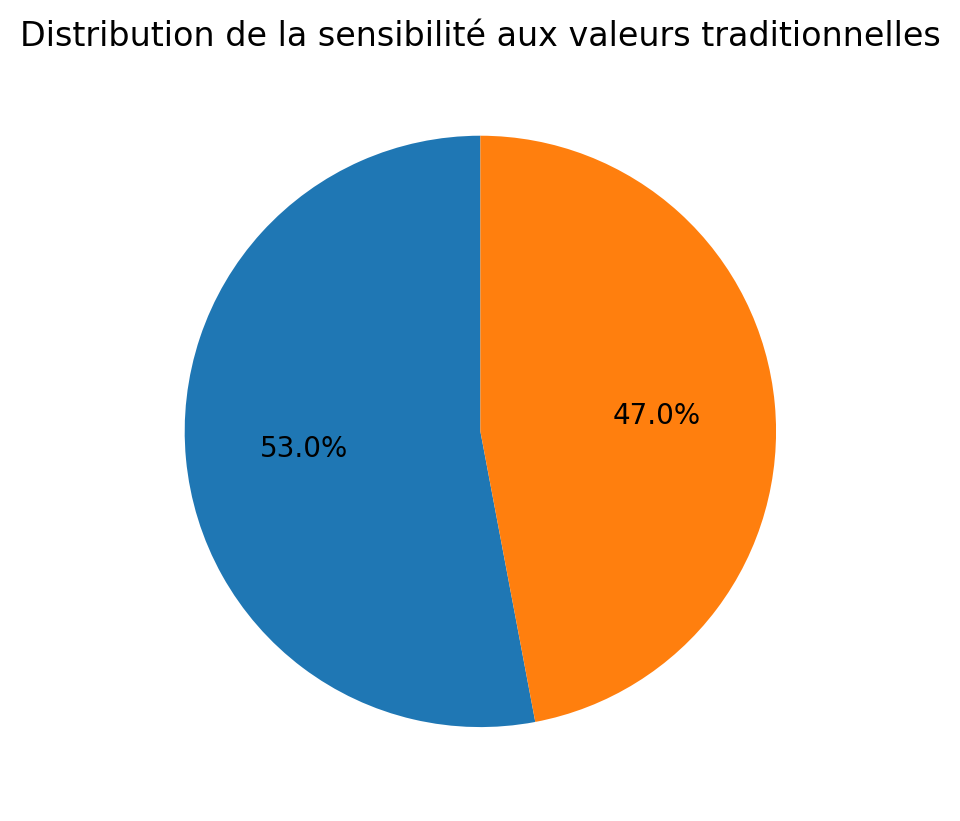

In [70]:
# 1. Distribution de la variable cible
plt.subplot()
tradition_value_sensibility = data_enough_values[label_name].value_counts()
plt.pie(tradition_value_sensibility.values, autopct='%1.1f%%',
         startangle=90)
plt.title('Distribution de la sensibilité aux valeurs traditionnelles')

print(tradition_value_sensibility)

On supprime le biais lié à la mauvaise distribution du label dans le dataset

imptrad
1.0    8762
0.0    8762
Name: count, dtype: int64
Nouvelle dimension du dataset après équilibrage : (17524, 19)


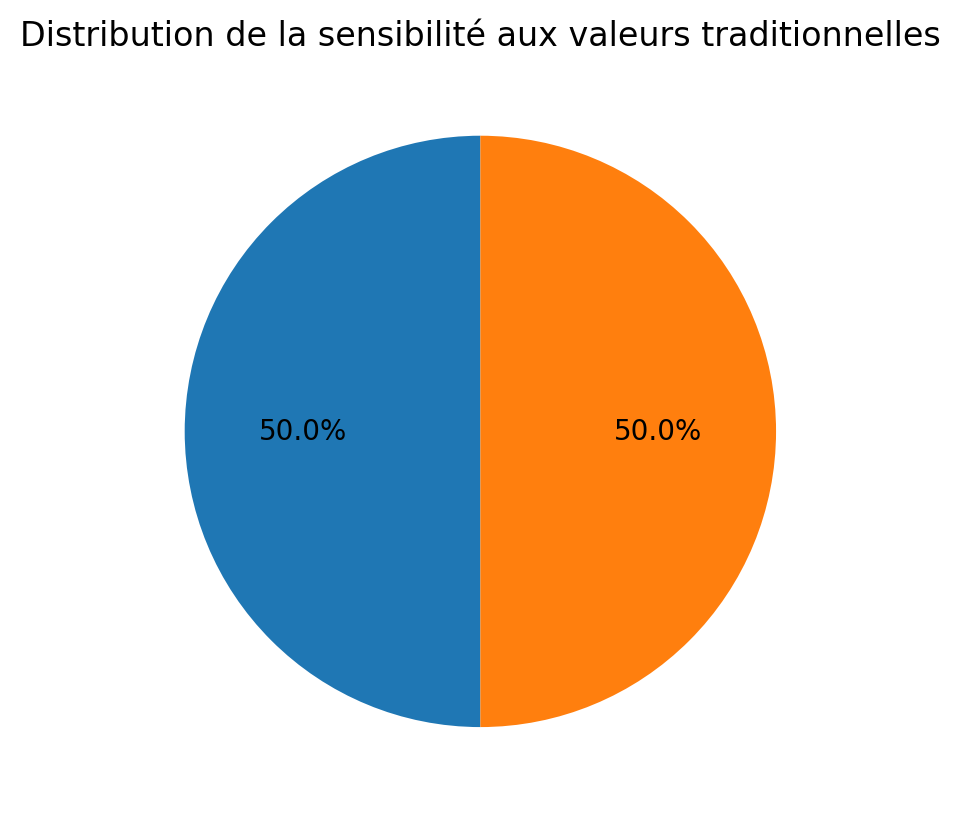

In [71]:
balanced_data = pd.DataFrame()
for value in tradition_value_sensibility.index:
    subset = data_enough_values[data_enough_values[label_name] == value].sample(n=np.min(tradition_value_sensibility), replace=True, random_state=42)
    balanced_data = pd.concat([balanced_data, subset])

tradition_value_sensibility_balanced = balanced_data[label_name].value_counts()

print(tradition_value_sensibility_balanced)


plt.pie(tradition_value_sensibility_balanced.values, autopct='%1.1f%%',
        startangle=90)
plt.title('Distribution de la sensibilité aux valeurs traditionnelles')

print(f"Nouvelle dimension du dataset après équilibrage : {balanced_data.shape}")


### Analyse descriptive

Analyse descriptive sur les features numériques pour détecter les éventuels outliers à supprimer

In [72]:
numerical_cols = ['agea', 'chldhm']

print("Analyse descriptive des données numériques")
balanced_data[numerical_cols].describe()

Analyse descriptive des données numériques


,agea,chldhm
count,17518.000000,13932.000000
mean,49.627983,1.649440
std,18.524854,0.477162
min,14.000000,1.000000
25%,35.000000,1.000000
50%,49.000000,2.000000
75%,64.000000,2.000000
max,99.000000,2.000000


Analyse descriptive des données catégorielles pour vérifier la cardinalité des features

In [73]:
print("Analyse descriptive des données catégorielles")
balanced_data.drop(numerical_cols, axis=1).astype(str).describe()


Analyse descriptive des données catégorielles


,ppltrst,lrscale,polintr,trstlgl,trstplc,trstplt,imwbcnt,rlgdgr,sclmeet,gndr,domicil,emplrel,tporgwk,imptrad,occupation,education,marital_status
count,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524,17524
unique,12,12,5,12,12,12,12,12,8,2,6,5,7,2,11,12,6
top,5.0,5.0,3.0,5.0,7.0,5.0,5.0,0.0,6.0,2,3.0,1.0,4.0,1.0,3,0003,1.0
freq,4712,4803,6312,3603,3420,3265,6423,4244,5824,9427,5822,12074,7113,8762,3303,4543,6984


### Matrice de corrélation

Il s'agit de vérifier la corrélation qui existe entre les différentes features et le label pour vérifier s'il est possible de simplifier le dataset.

Text(0.5, 1.0, 'correlation matrix')

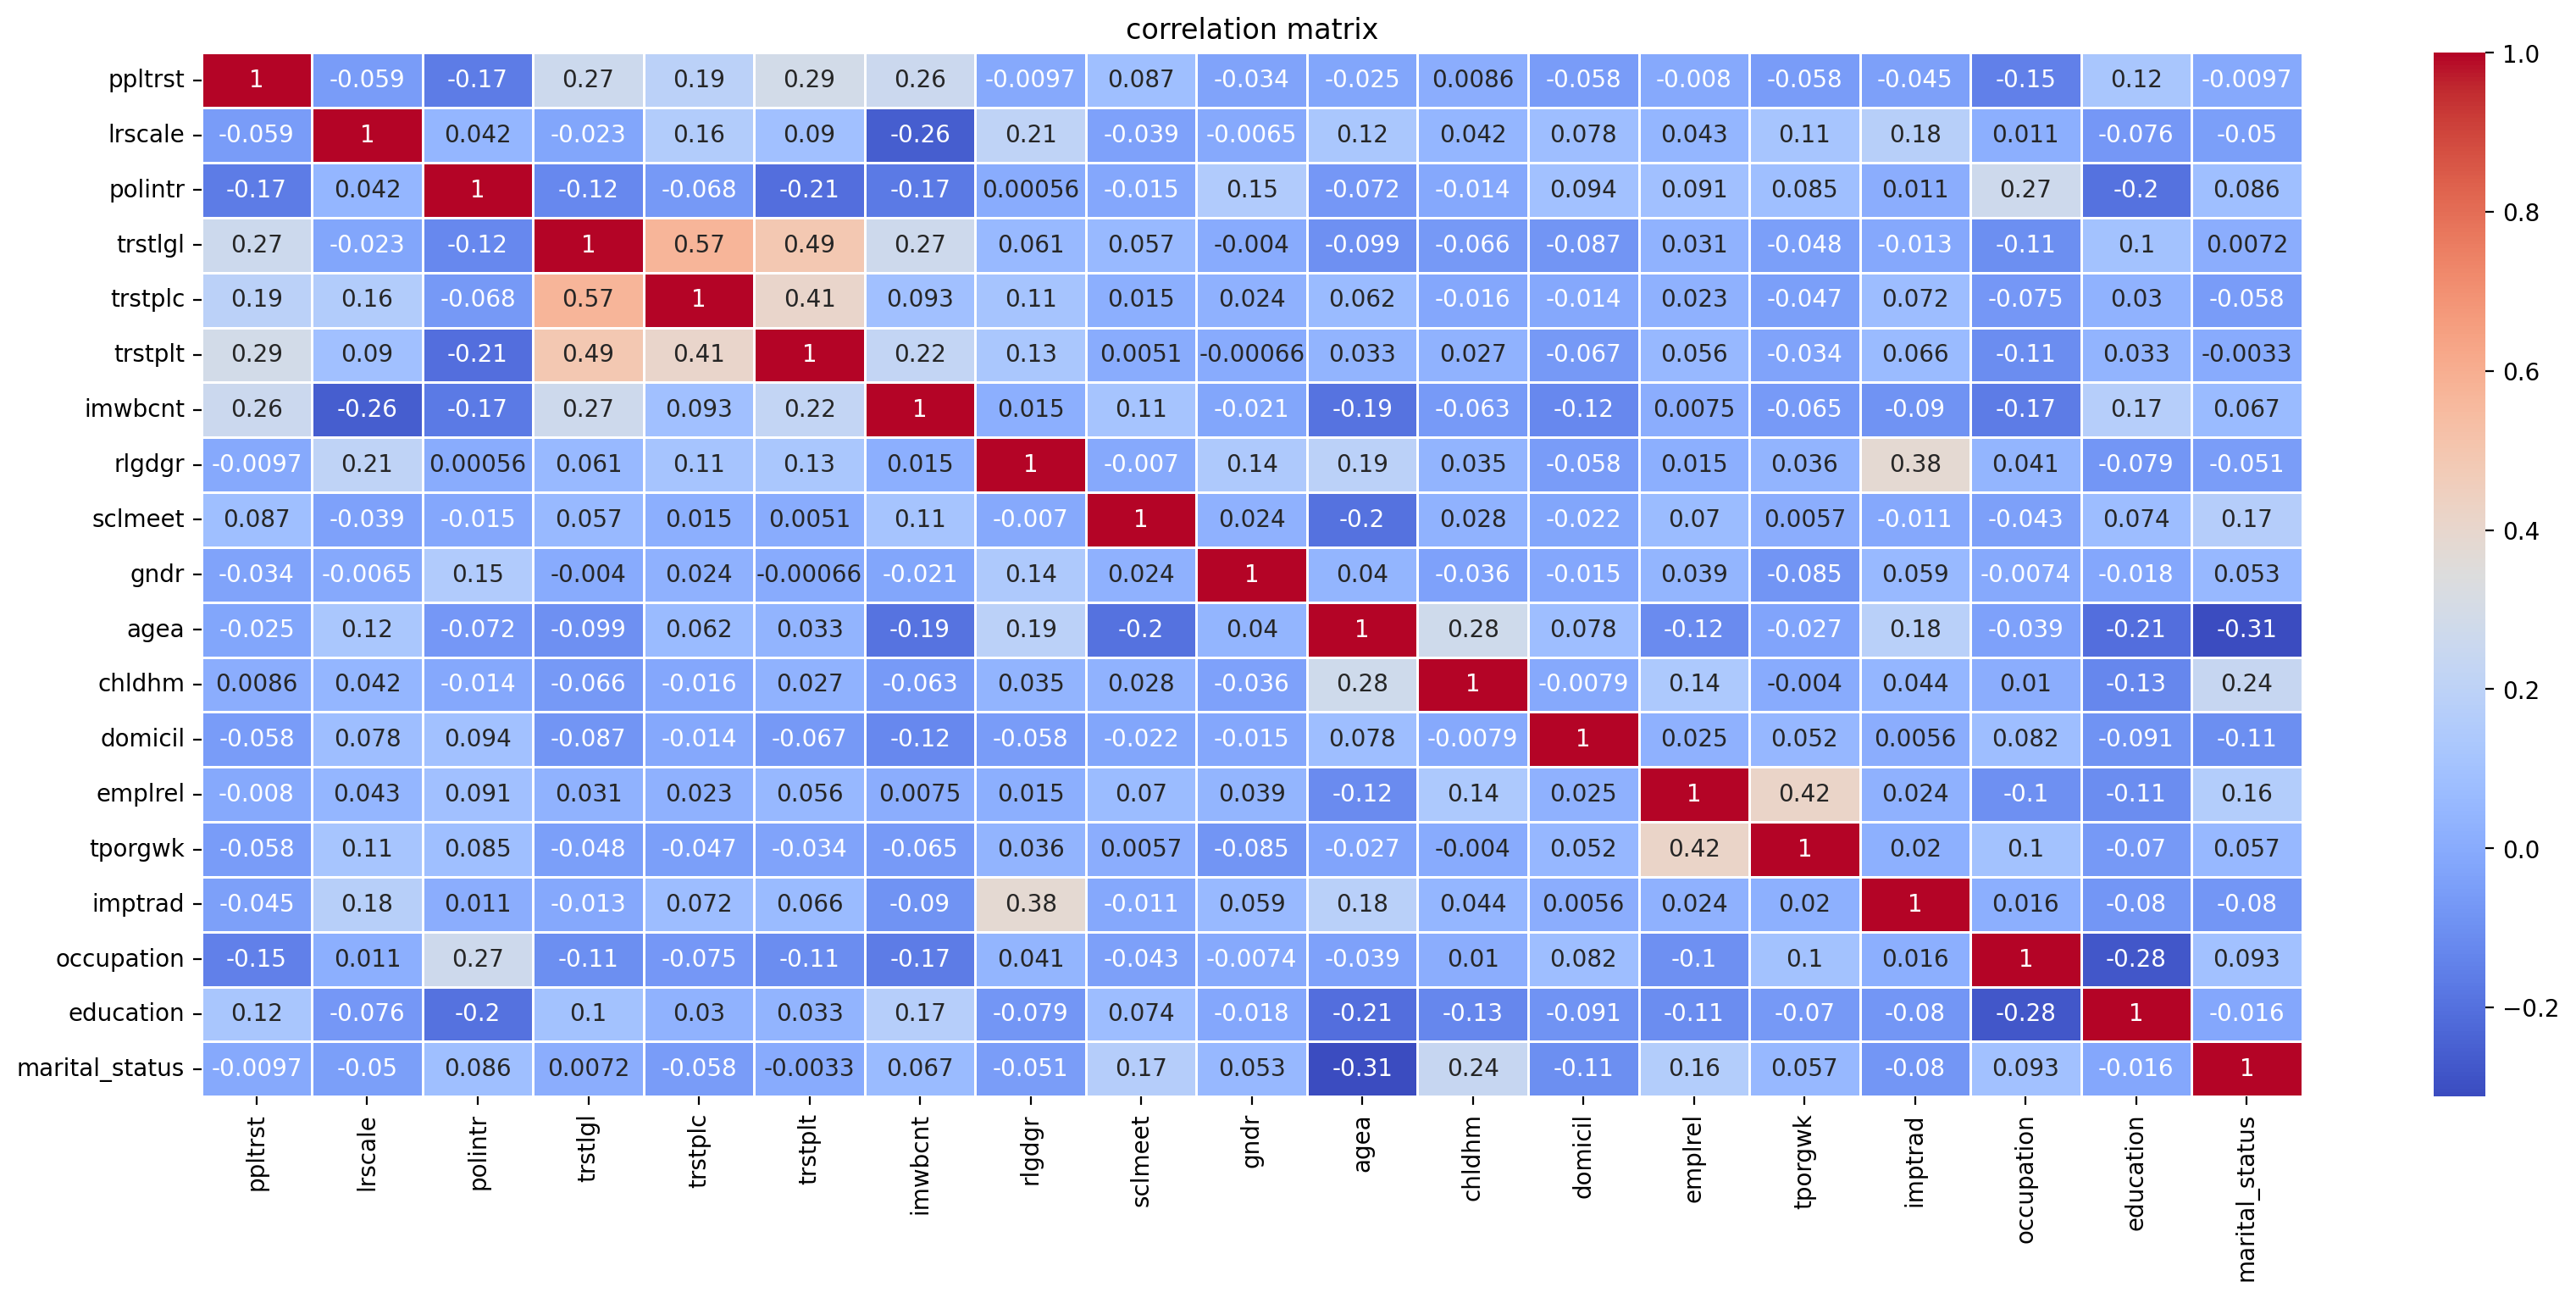

In [74]:
plt.figure(figsize=(20,8))
correlation_matrix = balanced_data.corr()
sns.heatmap(correlation_matrix, annot =True, cmap='coolwarm', linewidths=0.5)
plt.title('correlation matrix')

## Préparation des données d'entrainement

### Séparation des données d'entrainement et de test
Ratio
 - 80 % du dataset pour l'entrainement
 - 20 % du dataset pour les tests

In [75]:
X = balanced_data.drop(label_name, axis=1)
y = balanced_data[label_name]

X_unbalanced = data_enough_values.drop(label_name, axis=1)
y_unbalanced = data_enough_values[label_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,ppltrst,lrscale,polintr,trstlgl,trstplc,trstplt,imwbcnt,rlgdgr,sclmeet,gndr,agea,chldhm,domicil,emplrel,tporgwk,occupation,education,marital_status
402710,8.0,2.0,2.0,9.0,8.0,6.0,8.0,2.0,6.0,1,29.0,NaN,4.0,1.0,3.0,2,0005,5.0
355339,2.0,5.0,3.0,4.0,4.0,2.0,0.0,0.0,5.0,1,29.0,1.0,3.0,1.0,4.0,3,0005,5.0
209905,5.0,2.0,2.0,3.0,4.0,3.0,5.0,3.0,4.0,1,65.0,2.0,3.0,1.0,4.0,8,0003,4.0
62670,4.0,5.0,2.0,7.0,7.0,4.0,5.0,5.0,7.0,2,34.0,1.0,4.0,NaN,NaN,3,5.0,NaN
62097,4.0,8.0,2.0,5.0,8.0,7.0,3.0,7.0,6.0,2,77.0,2.0,5.0,NaN,NaN,NaN,1.0,NaN


### Création d'un pipeline de préprocessing de données
- Imputation
  - Imputation par la valeur la plus fréquente pour toutes les features
- Encodage des données catégorielles
  - Les données catégorielles et le label sont déjà encodés. Il n'y a pas de traitement à réaliser
- Normalisation
  - Normalisation "robuste" des features pour isoler les outliers

In [76]:
categorical_cols = X.drop(numerical_cols, axis=1).columns


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(sparse_output=False)),
    ('scaler', RobustScaler())
])

# Pipeline pour les données numériques (Standardisation)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler())
])

# Preprocessing complet avec ColumnTransformer
pipeline_preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough')

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

X_train_scaled = pipeline_preprocessing.fit_transform(X_train)
X_test_scaled = pipeline_preprocessing.transform(X_test)

pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,-0.689655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.689655,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.551724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.517241,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.965517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Choix du modèle

Choix du modèle en basant sur les performances globales (accuracy) et sur la capacité à bien prédire les cas positifs (précision)

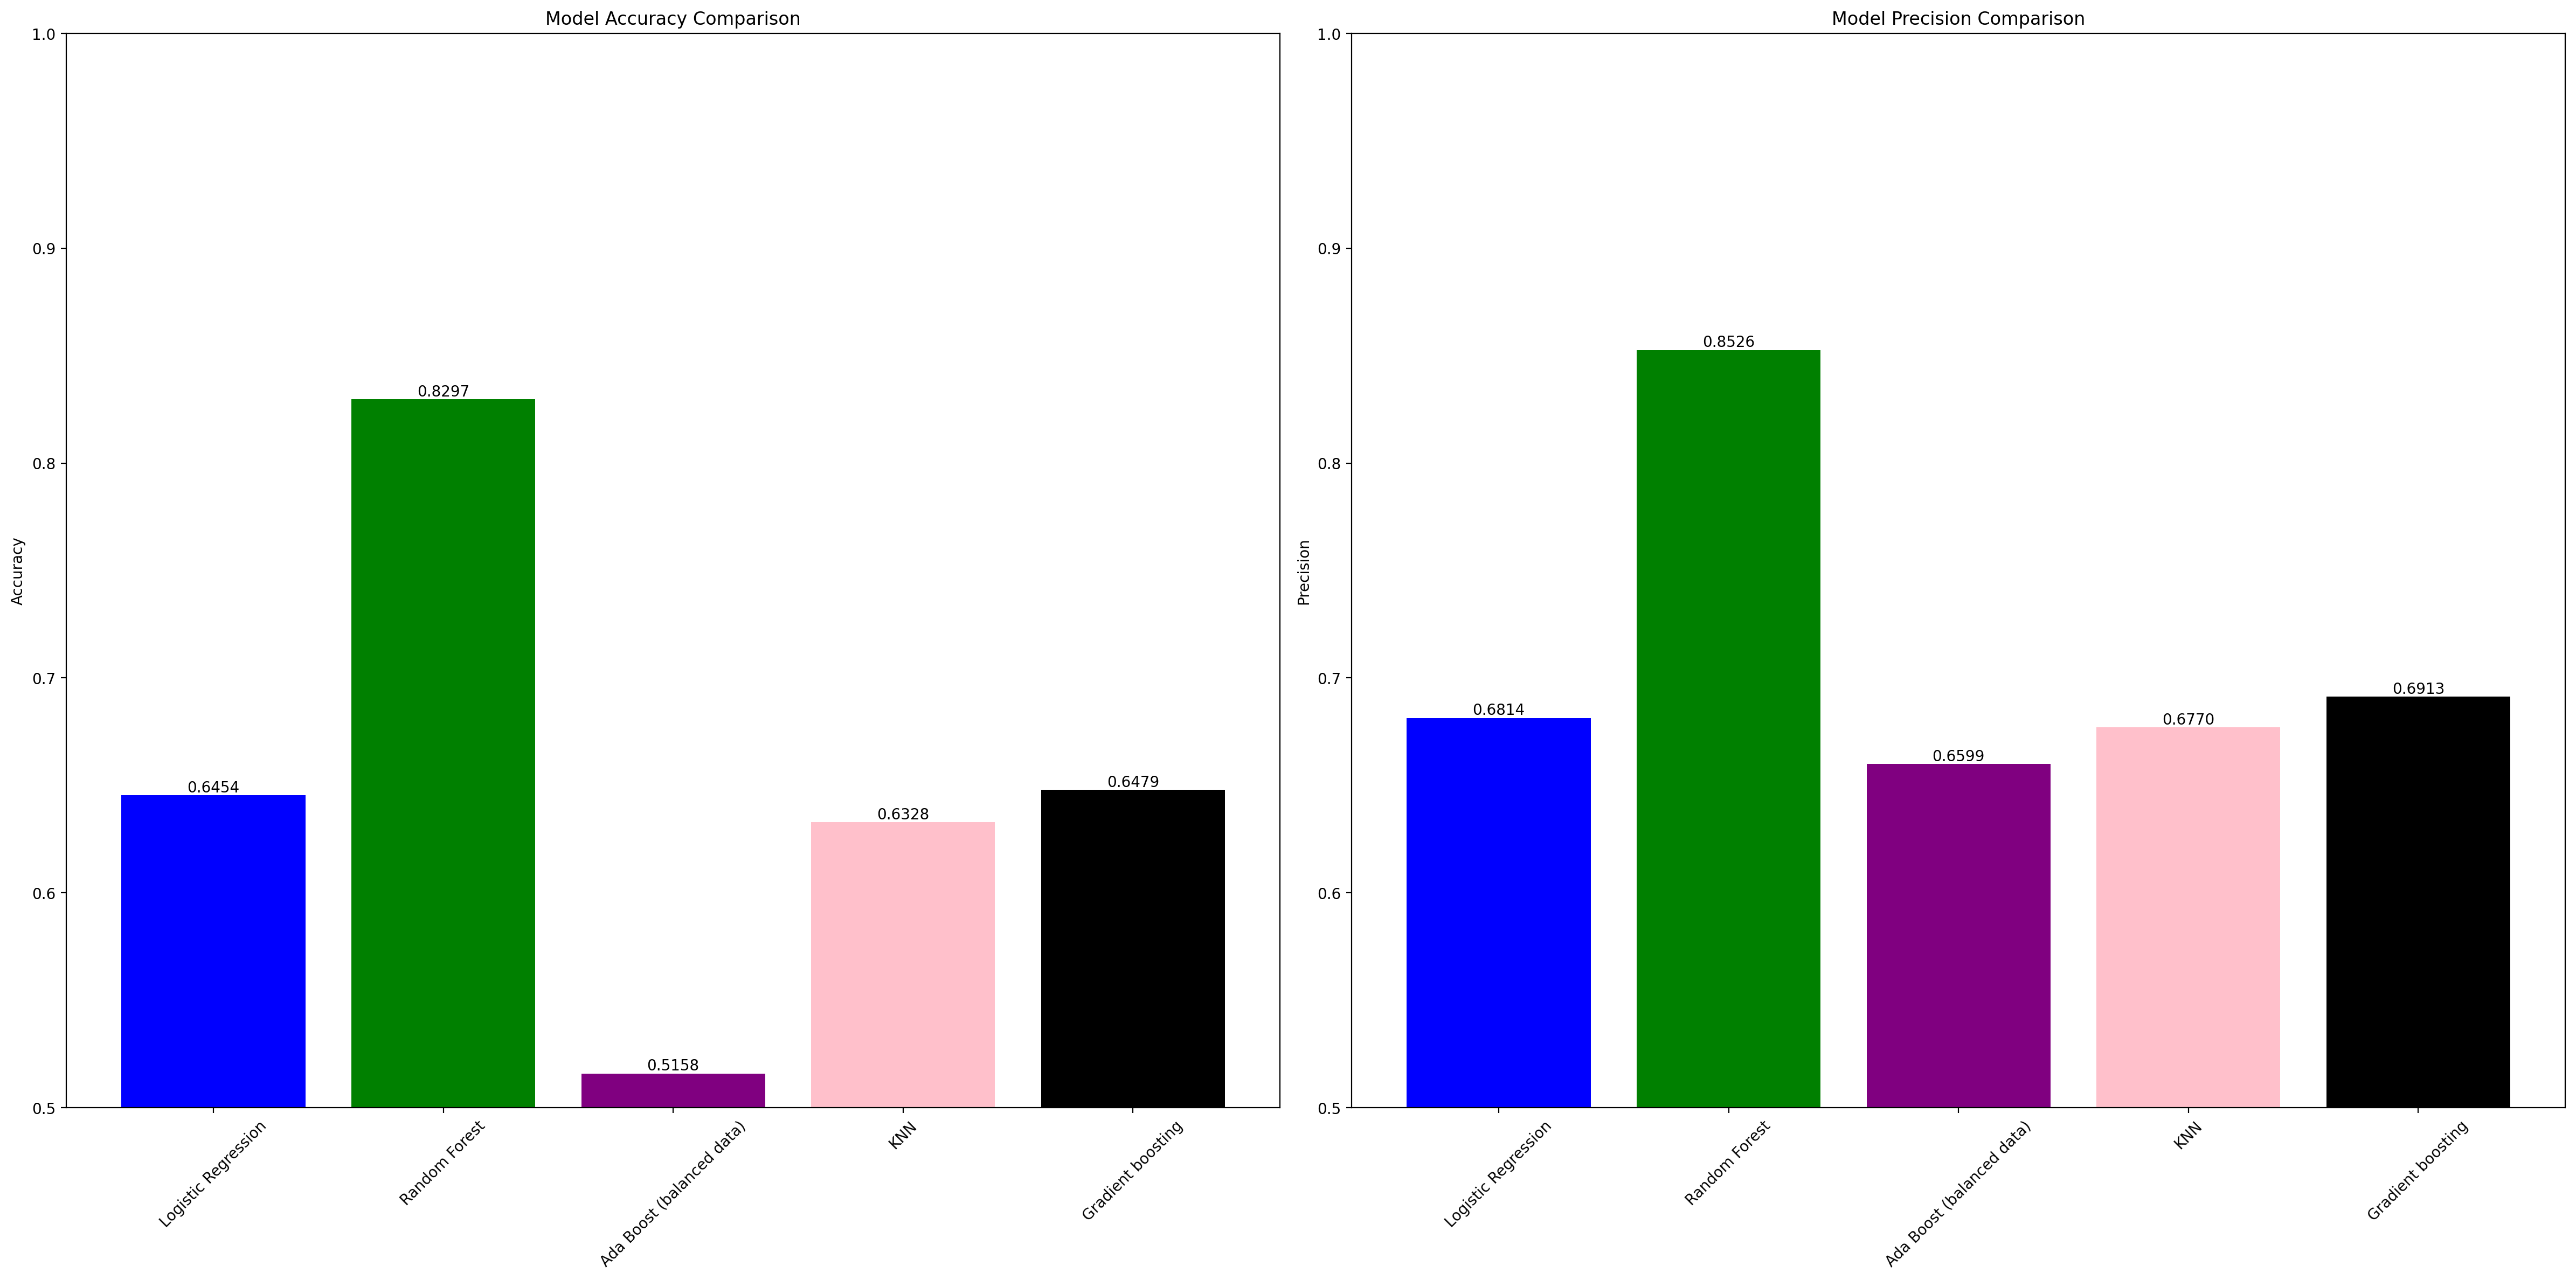

In [77]:
def predict(model, X):
    y_probs = model.predict_proba(X)[:, 1]
    custom_threshold = 0.65
    y_pred_adjusted = (y_probs >= custom_threshold).astype(int)
    return y_pred_adjusted

def get_metrics(parameters: list):
    accuracies = []
    labels = []
    colors = []
    precisions = []

    for model, X_train, y_train, X_test, y_test, label, color in parameters:
        model.fit(X_train, y_train)
        y_pred = predict(model, X_test)
        precision = precision_score(y_test, y_pred, average='weighted')
        
        colors.append(color)
        accuracies.append(accuracy_score(y_test, y_pred))
        labels.append(label)
        precisions.append(precision)

    return accuracies, labels, colors, precisions

def display_histogram(y: list, labels: list, ylabel: str, colors):
    bars = plt.bar(labels, y, color=colors, label=labels)
    plt.bar_label(bars, fmt='%.4f')
    plt.ylim(0.5, 1)
    plt.ylabel(ylabel)
    plt.title('Model {} Comparison'.format(ylabel))
    plt.xticks(rotation=45)


def display_metrics(parameters: list):    
    accuracies, labels, colors, precisions = get_metrics(parameters)

    plt.figure(figsize=(24, 12))

    plt.subplot(1, 2, 1)
    display_histogram(accuracies, labels, "Accuracy", colors)

    plt.subplot(1, 2, 2)
    display_histogram(precisions, labels, "Precision", colors)

    plt.tight_layout()  
    plt.show()



model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_rfc = RandomForestClassifier(random_state=42)
model_abc = AdaBoostClassifier(random_state=42)
model_abc_unbalanced = AdaBoostClassifier(random_state=42)
model_knn = KNeighborsClassifier()
model_gbc = GradientBoostingClassifier(random_state=42)


parameters = [
    (model_lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression', 'blue'),
    (model_rfc, X_train_scaled, y_train, X_test_scaled, y_test, 'Random Forest', 'green'),
    (model_abc, X_train_scaled, y_train, X_test_scaled, y_test, 'Ada Boost (balanced data)', 'purple'),
    (model_knn, X_train_scaled, y_train, X_test_scaled, y_test, 'KNN', 'pink'),
    (model_gbc, X_train_scaled, y_train, X_test_scaled, y_test, 'Gradient boosting', 'black')
]

display_metrics(parameters)    


On va chercher la combinaison d'hyper paramètre (autour des paramètres par défaut car les résultat sont déjà bon avec le paramétrage d'apprentissage par défaut) qui permet d'avoir les meilleurs résultats.

### Tunning des hyperparamètres du modèle choisi

In [78]:
# Estimation du max depth du modèle Random forest précédement entraîné
tree_max_depths = []
for tree in model_rfc.estimators_:
    tree_max_depths.append(tree.tree_.max_depth)

print("Max depths of individual trees:", tree_max_depths)

average_max_depth = sum(tree_max_depths) / len(tree_max_depths)
print(f"Average max depth of trees: {average_max_depth:.2f}")



Max depths of individual trees: [37, 40, 43, 52, 43, 41, 45, 43, 37, 42, 40, 41, 47, 46, 43, 44, 46, 42, 43, 43, 46, 42, 42, 45, 45, 41, 43, 37, 41, 47, 42, 46, 46, 44, 42, 43, 43, 46, 42, 46, 41, 49, 44, 43, 41, 40, 44, 42, 49, 49, 43, 42, 46, 40, 42, 45, 44, 40, 45, 46, 52, 40, 40, 43, 36, 38, 44, 44, 44, 42, 42, 43, 42, 46, 46, 43, 48, 53, 47, 40, 46, 43, 42, 44, 47, 39, 49, 43, 46, 43, 42, 45, 40, 46, 41, 41, 48, 38, 45, 45]
Average max depth of trees: 43.48


In [79]:
from scipy.stats import randint


param_distributions = {
    'n_estimators': randint(90, 110),
    'max_depth': randint(30, 50),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=model_rfc,
    param_distributions=param_distributions,
    n_iter=20, 
    cv=5,      
    verbose=1,  # Print progress messages
    random_state=42,
    scoring='precision', 
    n_jobs=-1
)
# Entraînement du modèle avec GridSearch
random_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
print("\nMeilleurs hyperparamètres trouvés:")
print(random_search.best_params_)
    
# Meilleur score
print(f"Meilleur score de validation: {random_search.best_score_:.2%}")
# Entraînement du modèle avec les meilleurs hyperparamètres
best_model = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Meilleurs hyperparamètres trouvés:
{'bootstrap': True, 'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 104}
Meilleur score de validation: 82.57%


### Evaluation du modèle

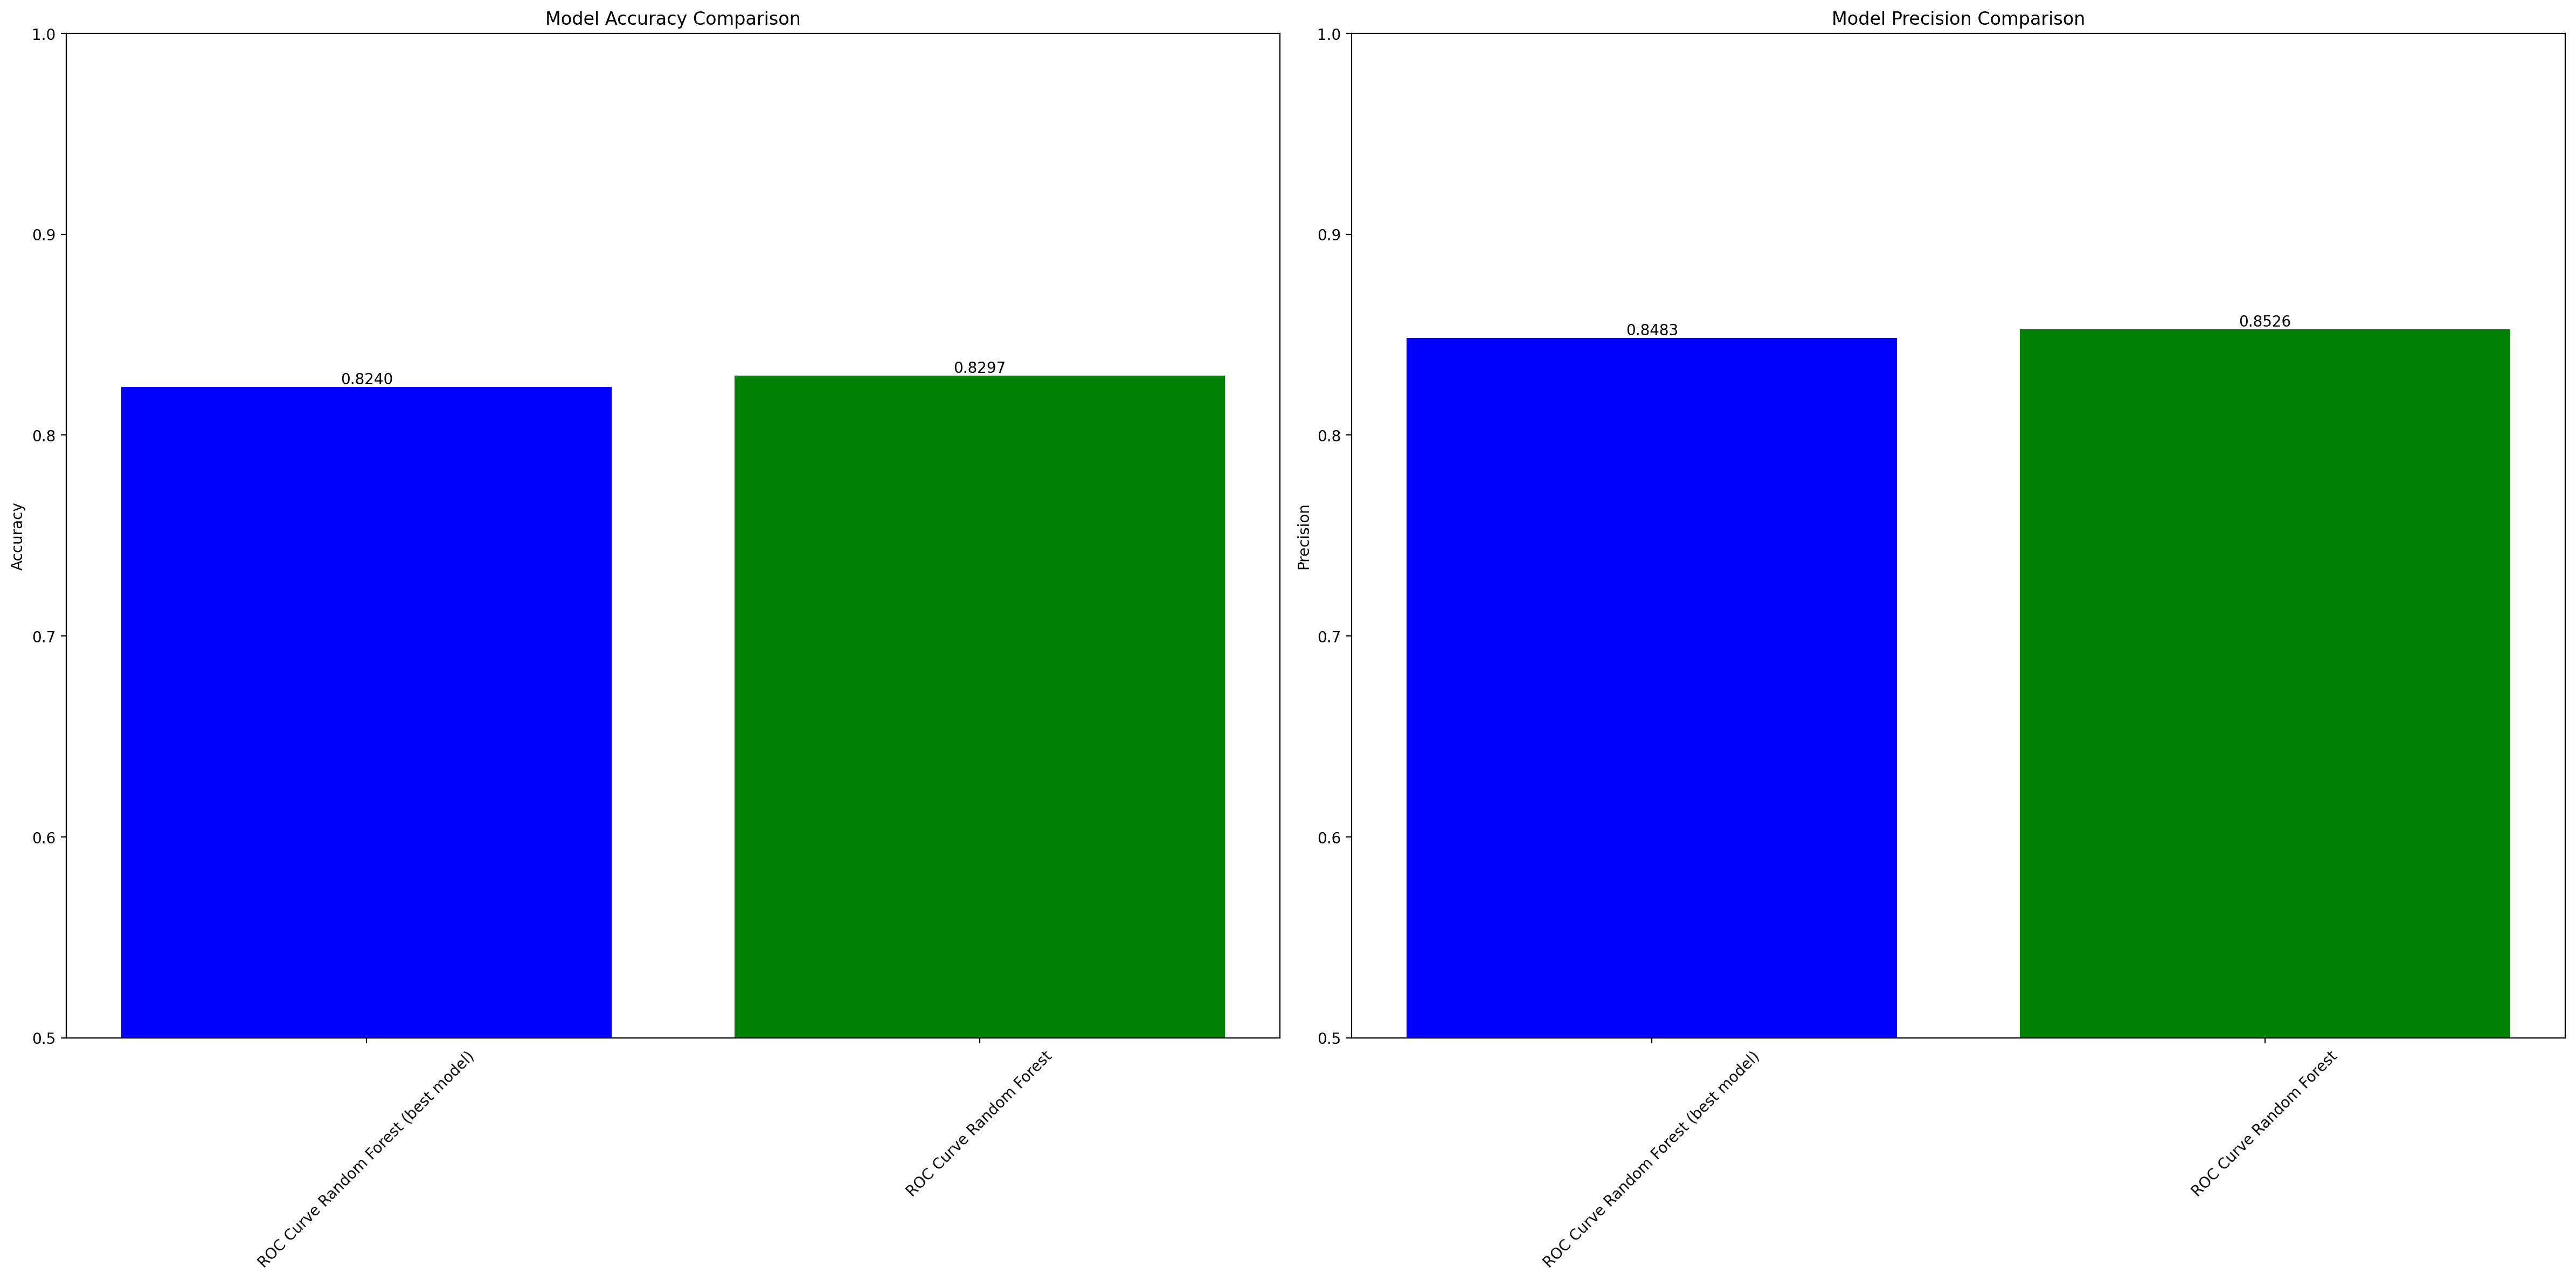

In [80]:
# Evaluation de l'effet du tunning d'hyperparamètres
parameters_rfc = [
    (best_model, X_train_scaled, y_train, X_test_scaled, y_test, 'ROC Curve Random Forest (best model)', 'blue'),
    (model_rfc, X_train_scaled, y_train, X_test_scaled, y_test, 'ROC Curve Random Forest', 'green')
]

best_model.fit(X_train_scaled, y_train)

display_metrics(parameters_rfc)

              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84      1729
         1.0       0.94      0.70      0.80      1776

    accuracy                           0.82      3505
   macro avg       0.85      0.83      0.82      3505
weighted avg       0.85      0.82      0.82      3505

Train precision: 0.9989
Test precision: 0.8483


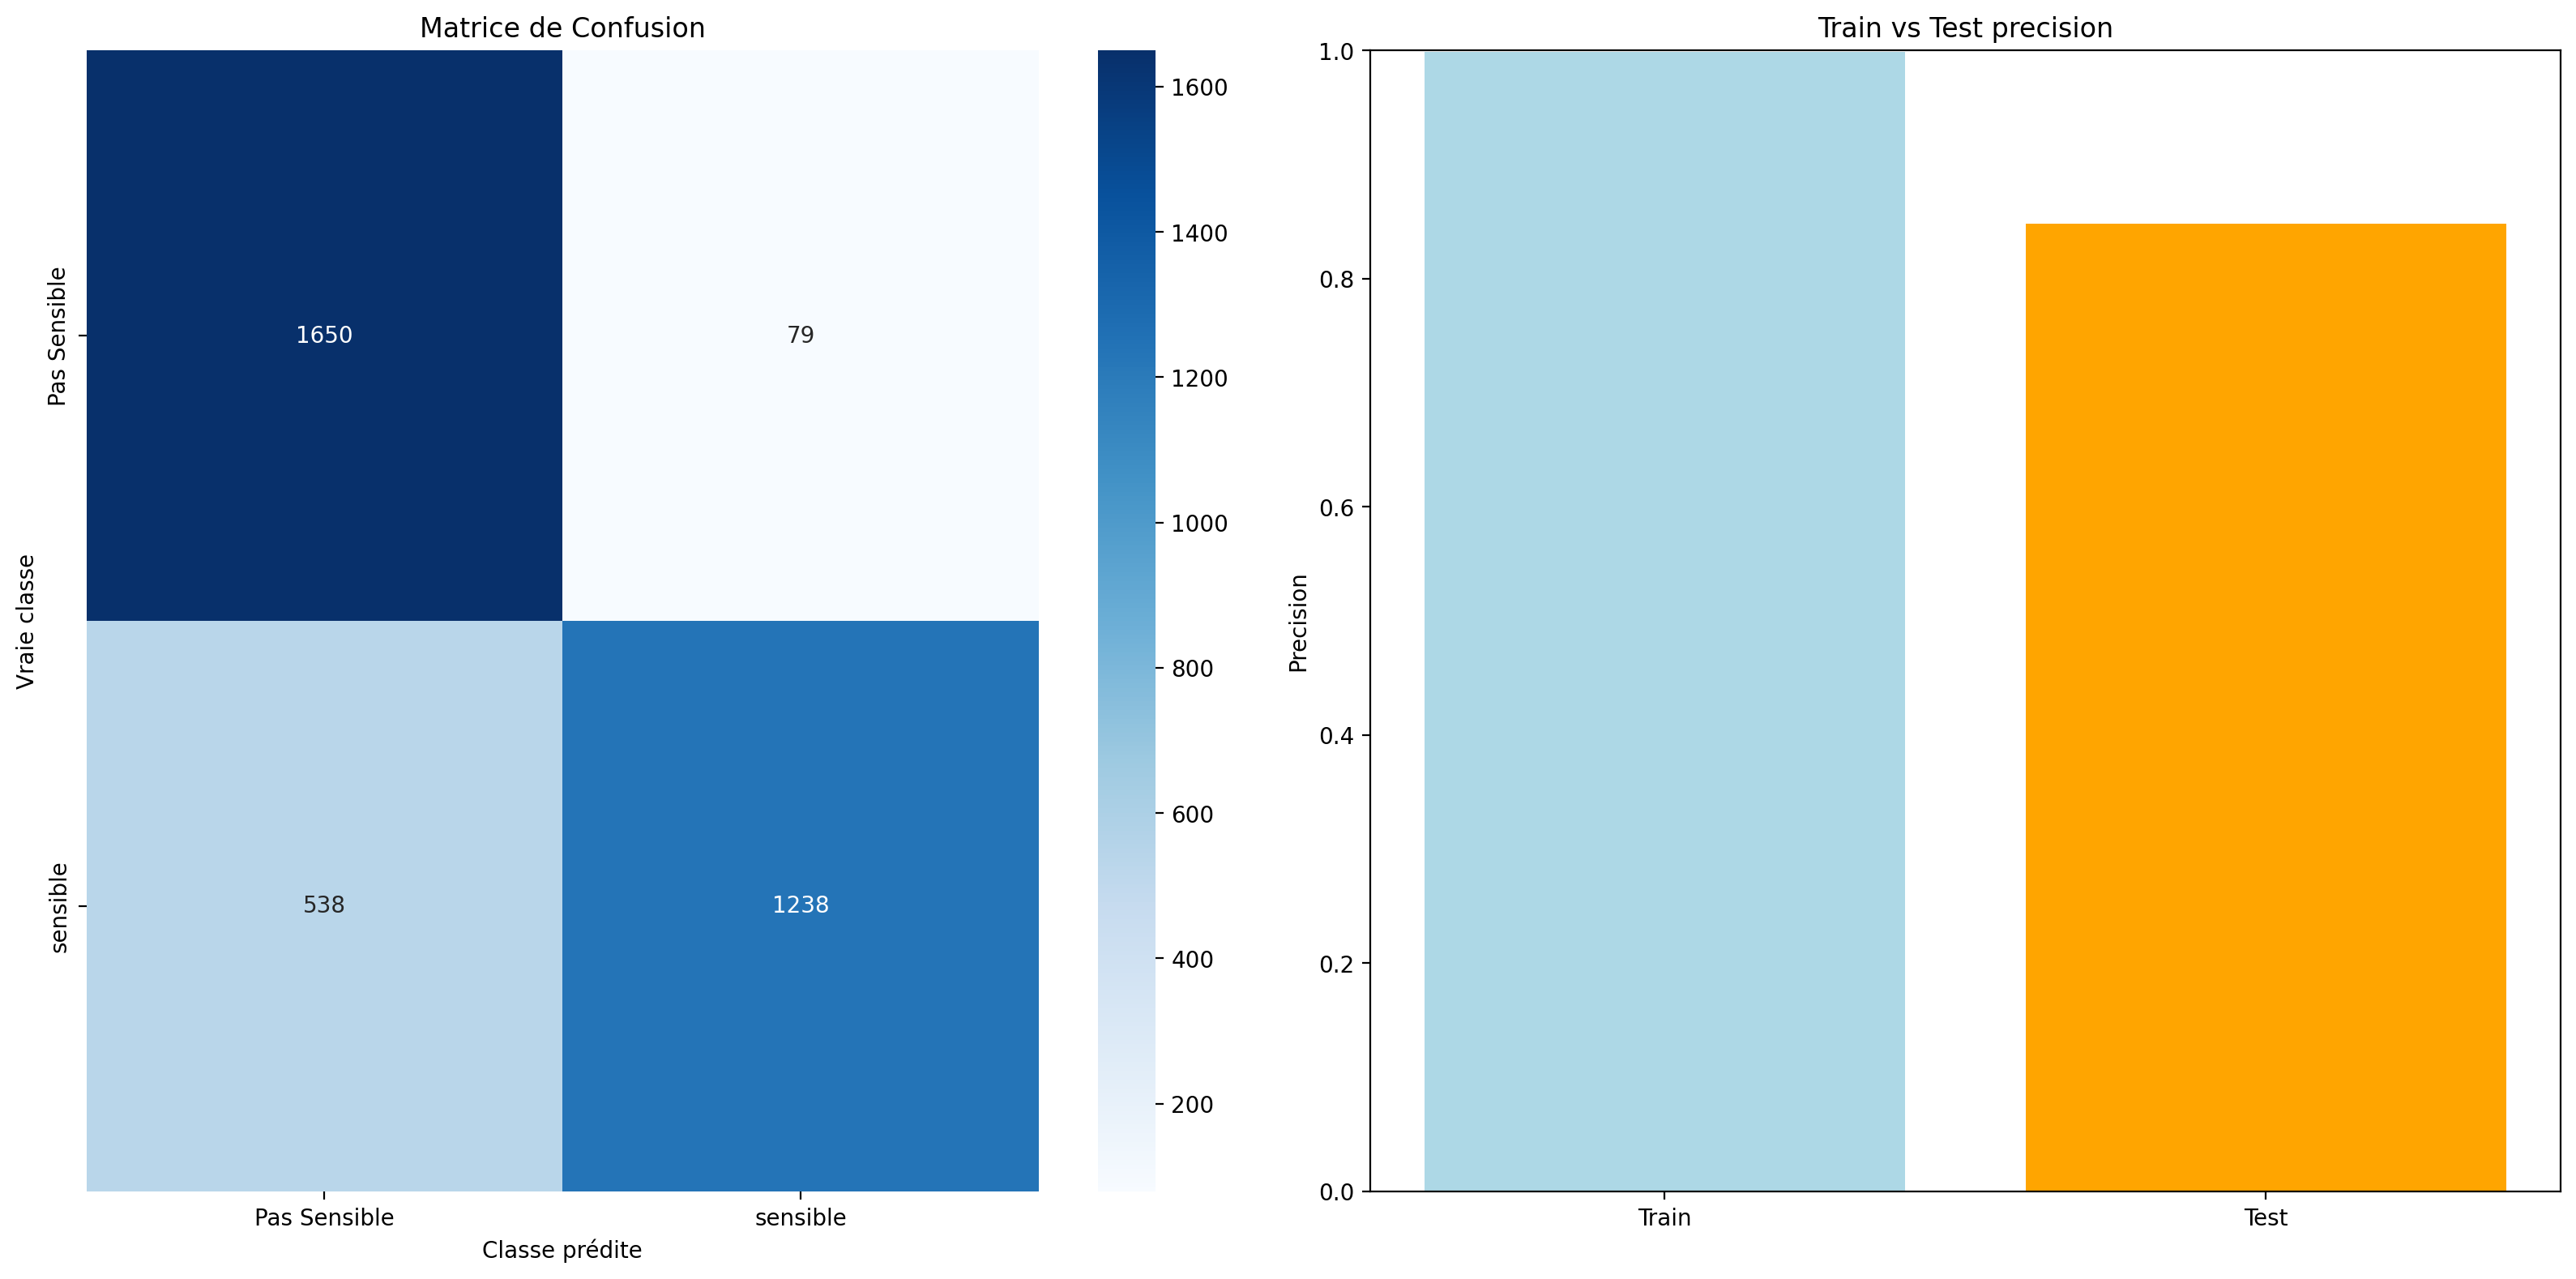

In [81]:

y_train_pred = predict(best_model, X_train_scaled)
y_test_pred = predict(best_model, X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

cm = confusion_matrix(y_test,y_test_pred)

#texte de rapport rapport plus precis de ce qu'on trouve
print(classification_report(y_test,y_test_pred))

train_precision = precision_score(y_train,y_train_pred, average='weighted')
test_precision = precision_score(y_test,y_test_pred, average='weighted')

print(f"Train precision: {train_precision:.4f}")
print(f"Test precision: {test_precision:.4f}")

# Display Confusion Matrix
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pas Sensible', 'sensible'],
            yticklabels=['Pas Sensible', 'sensible'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')

plt.subplot(1, 2, 2)
scores = [train_precision, test_precision]
labels = ['Train', 'Test']
colors = ['lightblue', 'orange']
plt.bar(labels, scores, color=colors)
plt.title('Train vs Test precision')
plt.ylabel('Precision')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [82]:
y_test = y_test.reset_index(drop=True)

for index in range(len(X_test_scaled)):
    proba = y_pred_proba[index]
    label = y_test[index]
    prediction = y_test_pred[index]

    if label == 0 and prediction == 1 and proba[1] > 0.7:
        print(proba)
    

[0.23076923 0.76923077]
[0.28846154 0.71153846]
[0.25961538 0.74038462]
[0.25961538 0.74038462]
[0.27884615 0.72115385]
[0.28846154 0.71153846]
[0.17307692 0.82692308]
[0.29807692 0.70192308]
[0.14697802 0.85302198]
[0.25 0.75]
[0.26923077 0.73076923]
[0.25961538 0.74038462]
[0.18269231 0.81730769]
[0.29807692 0.70192308]
[0.23076923 0.76923077]
[0.27234687 0.72765313]
[0.25961538 0.74038462]
[0.24038462 0.75961538]
[0.25 0.75]
[0.18269231 0.81730769]
[0.27884615 0.72115385]
[0.20192308 0.79807692]
[0.25 0.75]
[0.22115385 0.77884615]
[0.29807692 0.70192308]
[0.23076923 0.76923077]
[0.29807692 0.70192308]
[0.23076923 0.76923077]
[0.27197802 0.72802198]
[0.29807692 0.70192308]
[0.25961538 0.74038462]
[0.29807692 0.70192308]
[0.18269231 0.81730769]
[0.26923077 0.73076923]
[0.28846154 0.71153846]
[0.18269231 0.81730769]
[0.27884615 0.72115385]
[0.22115385 0.77884615]
[0.28846154 0.71153846]
[0.21153846 0.78846154]
[0.19230769 0.80769231]
[0.27884615 0.72115385]
[0.20192308 0.79807692]
[0.1